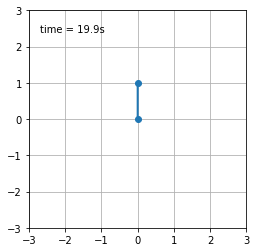

In [1]:
# ball: m = 1 kg
# pole: L = 1 m
# cart: M = 4 kg


import numpy as np

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import max_norm


# TODO should move all this to a module (probably merge with the old cartpole module we were using)

g = 9.81  # m/s^2
L = 1.0  # length of the pole (m)
M = 4.0  # mass of the cart (kg)
m = 1  # mass of the ball at the end of the pole (kg)

rad = np.pi / 180


# control input: u = F
# q is the state vector
def control(q):
    if (q[0] < 140 * rad) or (q[0] > 220 * rad):
        # swing up
        # energy error: Ee
        Ee = 0.5 * m * L * L * q[2] ** 2 - m * g * L * (1 + cos(q[0]))
        # energy control gain:
        k = 0.23
        # input acceleration: A (of cart)
        A = k * Ee * cos(q[0]) * q[2]
        # convert A to u (using EOM)
        delta = m * sin(q[0]) ** 2 + M
        u = A * delta - m * L * (q[2] ** 2) * sin(q[0]) - m * g * sin(q[2]) * cos(q[2])
    else:
        # balancing
        # LQR: K values from MATLAB
        k1 = 140.560
        k2 = -3.162
        k3 = 41.772
        k4 = -8.314
        u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
    return u


# state vector: q = transpose([theta, x, d(theta)/dt, dx/dt])
def derivs(q, t):
    dqdt = np.zeros_like(q)

    # control input
    u = control(q)

    delta = m * sin(q[0]) ** 2 + M

    dqdt[0] = q[2]
    dqdt[1] = q[3]

    dqdt[2] = - m * (q[2] ** 2) * sin(q[0]) * cos(q[0]) / delta \
              - (m + M) * g * sin(q[0]) / delta / L \
              - u * cos(q[0]) / delta / L

    dqdt[3] = m * L * (q[2] ** 2) * sin(q[0]) / delta \
              + m * L * g * sin(q[0]) * cos(q[0]) / delta / L \
              + u / delta

    return dqdt


# time step
dt = 0.1
t = np.arange(0.0, 20, dt)

rad = np.pi / 180


num_trials = 100
num_states = 4
num_t = len(t)
y = np.zeros((num_t, num_states, num_trials))

for i in range(num_trials):
    # initial conditions
    theta = 0
    x = 0.0
    th_dot = 2*(i/num_trials) - 1  # an initial velocity, triggers the swing up control
    xdot = 0.0

    # initial state
    state = np.array([theta, x, th_dot, xdot])

    # integrate the ODE using scipy.integrate.
    y[:, :, i] = integrate.odeint(derivs, state, t)


#animation generation
def animate_pend(y):
    th = y[:,0]
    x1 = y[:,1]
    y1 = 0.0

    x2 = L * sin(th) + x1
    y2 = -L * cos(th) + y1

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, aspect='equal', \
                     xlim=(-3, 3), ylim=(-3, 3))
    ax.grid()

    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text


    def animate(i):
        thisx = [x1[i], x2[i]]
        thisy = [y1, y2[i]]

        line.set_data(thisx, thisy)
        time_text.set_text(time_template % (i * dt))
        return line, time_text


    return animation.FuncAnimation(fig, animate, np.arange(1, len(y)), interval=40, blit=True, init_func=init)


ani = animate_pend(y[:,:,0])
#HTML(ani.to_jshtml())

# show the animation
#ani
HTML(ani.to_html5_video())

#plt.figure()

#plt.plot(y[:,1,1])
#plt.show()


In [ ]:
# Create our LSTM network

look_back = 3000

with tf.variable_scope('pi/pol/'):
    model = Sequential()
    model.add(Embedding(1,12,input_length = look_back))
    model.add(LSTM(12, return_sequences = True))
    #model.add(LSTM(4, input_shape =(12,look_back)))
    model.add(TimeDistributed(Dens(1)))

    #model.add(Dense(2))
    

model.compile(loss='mean_squared_error', optimizer='adam')

In [3]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Using TensorFlow backend.


FileNotFoundError: [Errno 2] No such file or directory: 'international-airline-passengers.csv'

In [ ]:
# you can either go ahead and fit the model or load weights, this cell will go ahead and run the fit routine

history = model.fit(np.transpose(training_input), np.transpose(training_output), epochs=20, verbose=0)

plot(history.history['loss'])
title('model loss')
ylabel('loss')
xlabel('epoch')
legend(['train', 'test'], loc='upper left')